In [1]:
import datetime
from pathlib import Path
from typing import Dict, List, Union

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")


%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams.update({'figure.max_open_warning': 0})
PARAMS = {'legend.fontsize': 'xx-large',
          'legend.title_fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(PARAMS)

TIME_FORMAT = '%Y-%m-%d'
INT_TYPE = 'int32'

In [2]:
def weighted_avg(x, weight, factor):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        tmp = x[[weight, factor]].dropna()
        weighted_sum = (tmp[weight] * tmp[factor]).sum()
        count_sum = tmp[weight].sum()
        return weighted_sum / count_sum

In [3]:
def load_data(locus_weights_path: Union[str, Path],
              temperature_path: Union[str, Path],
              locus_group_matching_path: Union[str, Path],
              fresh_water_dates_path: Union[str, Path],
              sw_fw_matching_path: Union[str, Path],
              sw_fw_matching_path_with_cnt: Union[str, Path],
              final_locus_weighted_path: Union[str, Path],
              mortality_path: Union[str, Path]) -> Dict[str, pd.DataFrame]:

    locus_weights = pd.read_csv(locus_weights_path)
    locus_weights.starttime = pd.to_datetime(locus_weights.starttime, format=TIME_FORMAT)
    locus_weights.endtime = pd.to_datetime(locus_weights.endtime, format=TIME_FORMAT)

    temperature = pd.read_csv(temperature_path)
    temperature.event_date = pd.to_datetime(temperature.event_date, format=TIME_FORMAT)
    temperature.locus_group_id=temperature.locus_group_id.astype(INT_TYPE)
    temperature['event_year'] = temperature['event_date'].dt.year

    locus_group_matching = pd.read_csv(locus_group_matching_path)
    locus_group_matching = locus_group_matching.astype(INT_TYPE)

    fresh_water_dates = pd.read_csv(fresh_water_dates_path)
    for d in ['first_movement_date', 'first_feeding_date', 'shipout_date']:
        fresh_water_dates[d] = pd.to_datetime(fresh_water_dates[d], format=TIME_FORMAT)

    sw_fw_matching = pd.read_csv(sw_fw_matching_path)
    sw_fw_matching_with_cnt = pd.read_csv(sw_fw_matching_path_with_cnt)

    sw_fw_cols = ['target_seawater_locus_id',
                  'transport_date',
                  'ponding_date',
                  'pretransfer_fw_locus_population_id',
                  'fish_count_shipped_out',
                  'avg_weight_g_stocked']
    sw_fw_matching = sw_fw_matching[sw_fw_matching.origin_site_type == 'Freshwater'][sw_fw_cols]
    sw_fw_matching.pretransfer_fw_locus_population_id = sw_fw_matching.\
    pretransfer_fw_locus_population_id.astype(INT_TYPE)

    final_locus_weighted = pd.read_csv(final_locus_weighted_path)
    final_locus_weighted.event_date = pd.to_datetime(final_locus_weighted.event_date)

    mortality = pd.read_csv(mortality_path)
    mortality['transfer_date'] = pd.to_datetime(mortality['transfer_date'], format=TIME_FORMAT)
    mortality['transport_year']= mortality['transfer_date'].dt.year


    dataframes = {
        'temperature': temperature,
        'locus_weigts': locus_weights,
        'locus_group_matching': locus_group_matching,
        'final_locus_weighted': final_locus_weighted,
        'fresh_water_dates': fresh_water_dates,
        'sw_fw_matching': sw_fw_matching,
        'sw_fw_matching_with_cnt': sw_fw_matching_with_cnt,
        'mortality': mortality
    }

    return dataframes

def create_factors_df(agg_ph_df, factors, key_columns, weight_column, weighted_func):
    """Creates factors df on key_columns level using weight_column to calculate weighted average"""
    factors_dfs = []
    print('Weighting factors')
    for factor in tqdm(factors):
        tmp = agg_ph_df.groupby(key_columns)\
        .apply(weighted_func, weight_column, factor).reset_index().rename(columns={0: factor})
        factors_dfs.append(tmp)

    factor_df = factors_dfs[0]
    for df in factors_dfs[1:]:
        factor_df = factor_df.merge(df, on=key_columns, how='inner')
    return factor_df

In [4]:
dataframes = load_data(locus_weights_path='../data/evt_movement_ratio_with_dates.csv',
                       temperature_path='../data/temperature_for_CAM.csv',
                       locus_group_matching_path='../data/locus_locus_group_matching.csv',
                       fresh_water_dates_path='../data/FW_cycle_dates.csv',
                       sw_fw_matching_path='../data/seawater_freshwater_matching.csv',
                       sw_fw_matching_path_with_cnt='../data/sw_locus_fw_locus_population_with_counts.csv',
                       final_locus_weighted_path='../data/lw_alldates_final.csv', #_locus
                       mortality_path='../data/smolt_dataset_transfers.csv') #_until2023Feb28_narrow

temperature = dataframes['temperature']
locus_weights = dataframes['locus_weigts']
locus_group_matching = dataframes['locus_group_matching']
final_locus_weighted = dataframes['final_locus_weighted']
fresh_water_dates = dataframes['fresh_water_dates']
sw_fw_matching = dataframes['sw_fw_matching']
mortality = dataframes['mortality']
sw_fw_matching_with_cnt = dataframes['sw_fw_matching_with_cnt']

sw_fw_matching_with_cnt['transfer_date'] = pd.to_datetime(sw_fw_matching_with_cnt['transfer_date'], format=TIME_FORMAT)
sw_fw_matching_with_cnt['transfer_year'] = sw_fw_matching_with_cnt['transfer_date'].dt.year

#tgc = pd.read_csv('data/transfers_until2023Feb28_with_sw_growth_targets.csv')

In [5]:
lw_dates = locus_weights.groupby('final_locus_population_id').agg({'starttime': 'min', 'endtime': 'max'})
lw_dates.starttime = pd.to_datetime(lw_dates.starttime, format=TIME_FORMAT)
lw_dates.endtime = pd.to_datetime(lw_dates.endtime, format=TIME_FORMAT)
lw_dates['FW_cycle_length'] = (lw_dates.endtime - lw_dates.starttime).dt.days + 1  # to be checked (?)
lw_dates['starttime_year'] = lw_dates['starttime'].dt.year
lw_dates = lw_dates[lw_dates.starttime_year>=2017]  # issues with temperature readings for 2015-2016

In [6]:
final_locus_locus_group_weighted = final_locus_weighted
# final_locus_locus_group_weighted = final_locus_weighted.merge(locus_group_matching,
#                                                               left_on='historic_locus_id',
#                                                               right_on='locus_id',
#                                                               how='left')
# final_locus_locus_group_weighted.drop(columns='locus_id',inplace=True)

In [7]:
final_locus_locus_group_weighted

,final_locus_population_id,event_date,historic_locus_id,weight
0,36770651,2015-05-15,3050549,1.0
1,36770651,2015-05-16,3050549,1.0
2,36770651,2015-05-17,3050549,1.0
3,36770651,2015-05-18,3050549,1.0
4,36770651,2015-05-19,3050549,1.0
...,...,...,...,...
41797572,194761283,2023-12-06,3048141,1.0
41797573,194761283,2023-12-07,3048141,1.0
41797574,194761283,2023-12-08,3048141,1.0
41797575,194761283,2023-12-09,3048141,1.0


### Feed data

In [8]:
feed_data = pd.read_csv('../data/feed_UPS_Petrohue.csv')
print('Rows count before merge:', feed_data.shape[0])
# feed_data = feed_data.merge(locus_group_matching, how='inner', on='locus_id')
# print('Rows count after merge:', feed_data.shape[0])
feed_data.rename(columns={'start_reg_time': 'event_date'}, inplace=True)
feed_data['event_date'] = pd.to_datetime(feed_data['event_date']) #, format=TIME_FORMAT
feed_data['event_year'] = feed_data['event_date'].dt.year
feed_data

Rows count before merge: 910765


,locus_id,mrts_feed_id,event_date,amount,locus_population_id,event_year
0,3046183,11416,2022-12-06,3.300,194526796,2022
1,3046598,11365,2022-12-06,5.200,194522458,2022
2,3046733,11416,2022-12-06,2.670,194524700,2022
3,3046802,11416,2022-12-06,2.278,194524704,2022
4,3047045,11416,2022-12-06,2.110,194524401,2022
...,...,...,...,...,...,...
910760,3051310,11403,2020-12-24,20.000,194274792,2020
910761,3051384,11661,2020-12-24,1.500,194276064,2020
910762,3051426,11940,2020-12-24,60.000,194272761,2020
910763,3051426,11366,2020-12-24,80.000,194272761,2020


In [9]:
# multiple_matching_ids = feed_data[
#     feed_data.groupby('locus_id')['locus_group_id'].transform('nunique') > 1
# ]['locus_id'].unique()

In [10]:
# feed_data[feed_data['locus_id'].isin(multiple_matching_ids)]

In [11]:
# # decided not to exclude this we work on locus_id level

# if False:
#     feed_data = feed_data[~feed_data['locus_id'].isin(multiple_matching_ids)]

#### Feed producer catalog

In [12]:
feed_catalog = pd.read_csv('../data\\dict_feed_name.csv')
feed_catalog['producer'] = feed_catalog['feed_name'].apply(lambda x: x.split()[0])

assert np.all(feed_catalog['producer'].apply(lambda x: len(x)) == 2)

In [13]:
feed_catalog

,mrts_feed_id,feed_name,producer
0,11492,"EW MICRO START 0,18\t\t\t\t\t\t\t\t",EW
1,12345,SK NUTRA SUPREME HE RCX 30 PF,SK
2,11348,BI ORBIT 1.5MM,BI
3,12087,"EW MICRO START 0,18 DERMIC FW",EW
4,11013,EW TRANSFER BOOST MED 50 FLO,EW
...,...,...,...
211,10960,"EW TRANSFER BOOST 100 BIOP ZN 0,5K/T",EW
212,11595,BI ORBIT INTRO 4MM QUICK VAC SRS,BI
213,11238,AS TRANSFER BOOST 100,AS
214,10802,"BI GOLDEN PRIMA PRO 0,3",BI


In [14]:
feed_data = feed_data.merge(feed_catalog[['mrts_feed_id', 'producer']], how='inner', on='mrts_feed_id')

In [15]:
# # change before merging

# if True: # reduce number of locus_ids to 10 since OOM
#     locus_fix = np.array([3050332, 3047666, 3047806, 3050820, 3049901, 3051154, 3047034,
#            3048582, 3049742, 3048644])

#     feed_data = feed_data[feed_data['locus_id'].isin(locus_fix)]

In [16]:
vaccines = pd.read_csv('../data/vaccines_with_final_locus_population_id.csv')
vaccines['VAC_EVENT_DATE'] = pd.to_datetime(vaccines['VAC_EVENT_DATE'] , format=TIME_FORMAT)
#DE: changed to max here
vaccines_agg = vaccines.groupby('FINAL_LOCUS_POPULATION_ID')[['VAC_EVENT_DATE']].max(numeric_only=False)

In [17]:
final_locus_locus_group_weighted#.dtypes

,final_locus_population_id,event_date,historic_locus_id,weight
0,36770651,2015-05-15,3050549,1.0
1,36770651,2015-05-16,3050549,1.0
2,36770651,2015-05-17,3050549,1.0
3,36770651,2015-05-18,3050549,1.0
4,36770651,2015-05-19,3050549,1.0
...,...,...,...,...
41797572,194761283,2023-12-06,3048141,1.0
41797573,194761283,2023-12-07,3048141,1.0
41797574,194761283,2023-12-08,3048141,1.0
41797575,194761283,2023-12-09,3048141,1.0


In [18]:
len(set(final_locus_locus_group_weighted.historic_locus_id))

502

In [19]:
len(set(feed_data.locus_id))

419

### To Final locus population level

In [20]:
if True:  # OOM, merge and save result to csv
    feed_data_final_lp = feed_data.merge(final_locus_locus_group_weighted,
                                         how='inner',
                                         left_on=['event_date', 'locus_id'],
                                         right_on=['event_date', 'historic_locus_id'])
    print(len(feed_data_final_lp))

25786908


In [21]:
feed_data_final_lp = feed_data_final_lp.merge(vaccines_agg,
                                              how='left',
                                              left_on='final_locus_population_id',
                                              right_index=True)
print(len(feed_data_final_lp))

25786908


In [22]:
final_locus_population_transfer_dates = sw_fw_matching_with_cnt[['from_locus_population_id','transfer_date']].groupby('from_locus_population_id').max()
feed_data_final_lp = feed_data_final_lp.merge(final_locus_population_transfer_dates,
                                     how='left',
                                     left_on='final_locus_population_id',
#                                      right_on='from_locus_population_id'
                                     right_index=True
                                             )
print(len(feed_data_final_lp))

25786908


In [23]:
# (feed_data_final_lp['transfer_date'] - feed_data_final_lp['VAC_EVENT_DATE']).dt.days.hist()

In [24]:
feed_data_final_lp['eight_weeks_before_transfer'] = feed_data_final_lp['transfer_date'] - pd.Timedelta(8,'w')

In [33]:
# locus_group_id_x, locus_group_id_y occur when merging with final_locus_locus_group_weighted not on locus_group_id
# np.all(feed_data_final_lp['locus_group_id_x'] == feed_data_final_lp['locus_group_id_y'])

In [27]:
if False:
    label_enc = LabelEncoder()
    one_hot_enc = OneHotEncoder(sparse=False)
    encoded_manufacturer = one_hot_enc.fit_transform(
        label_enc.fit_transform(feed_data_final_lp['manufacturer']).reshape(-1, 1)
)

In [49]:
#feed_data_final_lp = pd.read_csv('../data\\feed_data_final_lp.csv')

In [50]:
encoded_producer = pd.get_dummies(feed_data_final_lp['producer'])
feed_data_final_lp = feed_data_final_lp.drop('producer', axis=1)
feed_data_final_lp = feed_data_final_lp.join(encoded_producer)

In [51]:
feed_data_final_lp.to_csv('../data\\feed_data_final_lp.csv',index=False)

In [29]:
# feed_data_final_lp[feed_data_final_lp.final_locus_population_id==36770651].sort_values(by='event_date').tail(10)

In [30]:
# _ = feed_data_final_lp[feed_data_final_lp['final_locus_population_id'] == 36778733][
#     feed_data_final_lp['event_date'] == '2016-12-22']

In [31]:
feed_data_final_lp.\
groupby(['final_locus_population_id','event_date'])['weight'].sum().describe()

count    1.263657e+06
mean     2.548793e-01
std      4.592931e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.000000e+00
Name: weight, dtype: float64

In [32]:
# _

In [33]:
feed_data_final_lp['event_year'] = feed_data_final_lp['event_date'].dt.year

for col in tqdm(encoded_producer.columns):
    feed_data_final_lp[f'weight_{col}'] = feed_data_final_lp['weight'] * feed_data_final_lp[col]

weighted_producer_cols = ['weight_' + col for col in encoded_producer.columns]

feed_data_final_lp_grouped = feed_data_final_lp.\
groupby(['final_locus_population_id','event_date'])[weighted_producer_cols].sum()

100%|██████████| 5/5 [00:00<00:00,  9.76it/s]


In [34]:
feed_data_final_lp_eight_last_weeks=feed_data_final_lp[feed_data_final_lp.event_date.between(feed_data_final_lp['eight_weeks_before_transfer'],feed_data_final_lp['transfer_date'])]
# feed_data_final_lp_eight_last_weeks.to_csv('data\\feed_data_final_lp_eight_last_weeks.csv',index=False)
feed_data_final_lp_vacc_transfer=feed_data_final_lp[feed_data_final_lp.event_date.between(feed_data_final_lp['VAC_EVENT_DATE'],feed_data_final_lp['transfer_date'])]
# feed_data_final_lp_vacc_transfer.to_csv('data\\feed_data_final_lp_vaccination_transfer.csv',index=False)

In [35]:
# feed_data_final_lp[['locus_id', 'mrts_feed_id', 'event_date', 'amount',
#        'locus_population_id', 'final_locus_population_id', 'weight', 'VAC_EVENT_DATE', 'transfer_date',
#        'eight_weeks_before_transfer', 'BI', 'EU', 'EW', 'SK', 'ST']].to_csv('data\\feed_data_final_lp.csv',index=False)

In [36]:
feed_data_final_lp_grouped = feed_data_final_lp_grouped.reset_index()

In [37]:
# feed_data_final_lp_grouped[feed_data_final_lp_grouped['final_locus_population_id'] == 36770651][
#     feed_data_final_lp_grouped['event_date'] == '2015-11-18']

In [38]:
#DE: changed filter columns on weighted_producer_cols
feed_data_final_lp_grouped['weight_sum'] = feed_data_final_lp_grouped[weighted_producer_cols].sum(axis=1)

In [39]:
for col in weighted_producer_cols:
    feed_data_final_lp_grouped[col] = feed_data_final_lp_grouped[col] / feed_data_final_lp_grouped['weight_sum']

# feed_data_final_lp_grouped.drop('weight_sum', axis=1, inplace=True)

In [40]:
#if at least 50% of tanks were without feeding info
feed_data_final_lp_grouped['low_feeding_flag']=np.zeros(len(feed_data_final_lp_grouped))
feed_data_final_lp_grouped.loc[feed_data_final_lp_grouped['weight_sum']<0.5,'low_feeding_flag']=1
#if have two records on feed with different mrts_feed_id in the same date
feed_data_final_lp_grouped['double_feeding_flag']=np.zeros(len(feed_data_final_lp_grouped))
feed_data_final_lp_grouped.loc[feed_data_final_lp_grouped['weight_sum']>1.5,'double_feeding_flag']=1

feed_data_final_lp_grouped['low_feeding_flag']=feed_data_final_lp_grouped.low_feeding_flag.astype('int')
feed_data_final_lp_grouped['double_feeding_flag']=feed_data_final_lp_grouped.double_feeding_flag.astype('int')

In [41]:
# # feed_data_final_lp_grouped[feed_data_final_lp_grouped['final_locus_population_id']==36770651]
# plt.plot(feed_data_final_lp_grouped[feed_data_final_lp_grouped['final_locus_population_id']==36770651].event_date,
#          feed_data_final_lp_grouped[feed_data_final_lp_grouped['final_locus_population_id']==36770651].weight_sum)

In [42]:
# feed_data_final_lp_grouped[feed_data_final_lp_grouped['final_locus_population_id'] == 36770651][
#     feed_data_final_lp_grouped['event_date'] == '2015-11-18']

In [43]:
# for col in weighted_producer_cols:
#     sns.lineplot(data=feed_data_final_lp_grouped[feed_data_final_lp_grouped['final_locus_population_id'] == 36770651],
#                  x='event_date',
#                  y=col)

# plt.legend(weighted_producer_cols)

In [44]:
feed_producer_final_lp = feed_data_final_lp_grouped.groupby('final_locus_population_id').mean()
feed_producer_final_lp

,event_date,weight_BI,weight_EU,weight_EW,weight_SK,weight_ST,weight_sum,low_feeding_flag,double_feeding_flag
final_locus_population_id,,,,,,,,,
36770651,2016-03-08 13:20:43.049327360,1.000000,0.0,0.000000,0.000000,0.0,0.224215,0.802691,0.026906
36770663,2016-03-08 12:48:25.829596416,1.000000,0.0,0.000000,0.000000,0.0,0.197309,0.802691,0.000000
36770708,2016-03-12 13:20:41.379310336,1.000000,0.0,0.000000,0.000000,0.0,0.219828,0.788793,0.008621
36770798,2016-03-13 17:32:18.461538560,0.906250,0.0,0.093750,0.000000,0.0,0.243590,0.794872,0.038462
36770840,2016-03-14 09:17:37.021276672,0.914894,0.0,0.085106,0.000000,0.0,0.234043,0.800000,0.034043
...,...,...,...,...,...,...,...,...,...
194761270,2023-07-29 11:37:19.370078720,0.612903,0.0,0.000000,0.387097,0.0,0.248031,0.755906,0.003937
194761272,2023-07-30 00:00:00.000000000,1.000000,0.0,0.000000,0.000000,0.0,0.163424,0.836576,0.000000
194761274,2023-07-29 11:37:19.370078720,0.612903,0.0,0.000000,0.387097,0.0,0.248031,0.755906,0.003937


In [45]:
feed_producer_final_lp.to_csv('../data\\feed_producer_final_lp_ALL_DATES.csv')

In [ ]:
feed_producer_final_lp = pd.read_c

### To locus_id level

In [49]:
key_columns = ['locus_id','fish_group_id','transfer_year']

mortality_cols = ['locus_id',
                  'fish_group_id',
                  'transfer_year',
                  'transfer_month',
                  'transfer_month_year',
                  'transfer_season',
                  'transfer_season2',
                  'total_count',
                  'total_mortality_perc_90']

sw_cols = ['to_locus_id',
           'to_fish_group_id',
           'transfer_date',
           'from_locus_population_id',
           'from_count_stocking',
           'transfer_year']

mortality_final_locus = mortality[mortality_cols].merge(
    sw_fw_matching_with_cnt[sw_cols],
    left_on=['fish_group_id', 'locus_id','transfer_year'],
    right_on=['to_fish_group_id', 'to_locus_id','transfer_year'],
    how='left'
)


mortality_final_locus['from_locus_population_id'] = mortality_final_locus['from_locus_population_id'].fillna(0).astype('int32')

In [59]:
factors = factors.drop(['event_date'])

In [60]:
factors

Index(['double_feeding_flag', 'fish_group_id_x', 'fish_group_id_y',
       'from_count_stocking_x', 'from_count_stocking_y',
       'from_locus_population_id_x', 'from_locus_population_id_y',
       'locus_id_x', 'locus_id_y', 'low_feeding_flag', 'transfer_year_x',
       'transfer_year_y', 'weight_BI', 'weight_EU', 'weight_EW', 'weight_SK',
       'weight_ST', 'weight_sum'],
      dtype='object')

In [57]:
key_columns.append('event_date')

In [58]:
key_columns

['locus_id', 'fish_group_id', 'transfer_year', 'event_date']

In [55]:
feed_producer_final_lp = feed_producer_final_lp.merge(
    mortality_final_locus[['from_locus_population_id', 'locus_id','fish_group_id', 'transfer_year', 'from_count_stocking']],
    left_index=True,
    right_on=['from_locus_population_id',],
    how='right')

factors = feed_producer_final_lp.columns.difference(
    ['from_locus_population_id', 'locus_id', 'fish_group_id', 'transfer_year', 'from_count_stocking']
)

feed_producer = create_factors_df(feed_producer_final_lp,
                                     factors,
                                     key_columns,
                                     weight_column='from_count_stocking',
                                     weighted_func=weighted_avg)
feed_producer = feed_producer.merge(
    pd.DataFrame(mortality_final_locus.groupby(key_columns)['total_mortality_perc_90'].mean()),
    on=key_columns,
    how='inner')

#feed_producer = feed_producer.merge(
#    pd.DataFrame(tgc.groupby(key_columns)['TGC_SW'].mean()),
#    on=key_columns,
#    how='inner'
#)


Weighting factors


  0%|          | 0/19 [00:00<?, ?it/s]


KeyError: 'locus_id'

In [ ]:
feed_producer

In [ ]:

feed_producer.rename(columns={'total_mortality_perc_90': 'mortality'}, inplace=True)
sgr_factors.to_csv(f'../data/factors_{main_factor.lower()}.csv', index=False)

In [ ]:
feed_producer.dropna(inplace=True)

In [ ]:
feed_producer

,locus_id,fish_group_id,transfer_year,weight_BI,weight_EW,weight_SK,mortality,TGC_SW


In [ ]:
feed_producer['highest_type'] = feed_producer[weighted_producer_cols].idxmax(axis=1)
feed_producer['highest_type'] = feed_producer['highest_type'].apply(lambda x: x.split('_')[-1])

<AxesSubplot:xlabel='highest_type', ylabel='mortality'>

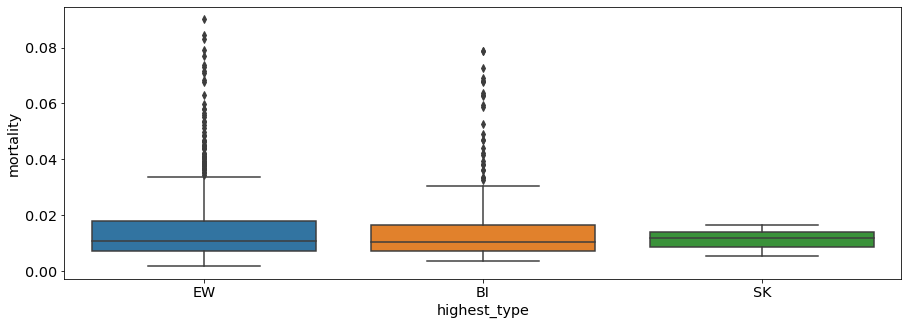

In [ ]:
sns.boxplot(data=feed_producer, x='highest_type', y='mortality')